In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [90]:
def random_number(min, max):
  return random.randint(min, max)

In [91]:
def generate_image(height, width):
  r = np.full((height, width), random_number(0, 255))
  g = np.full((height, width), random_number(0, 255))
  b = np.full((height, width), random_number(0, 255))

  rgb = np.dstack((r, g, b))
  return rgb

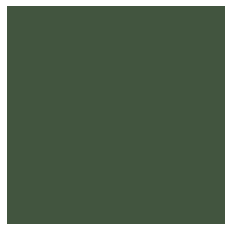

In [92]:
height = 256
width = 256

image = generate_image(height, width)

imgplot = plt.imshow(image)
plt.axis('off')
plt.show()